# Traffic Sign Recognition

This project is using the data from the [The German Traffic Sign Recognition Benchmark](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset)

    @inproceedings{Stallkamp-IJCNN-2011,
    author = {Johannes Stallkamp and Marc Schlipsing and Jan Salmen and Christian Igel},
    booktitle = {IEEE International Joint Conference on Neural Networks},
    title = {The {G}erman {T}raffic {S}ign {R}ecognition {B}enchmark: A multi-class classification competition},
    year = {2011},
    pages = {1453--1460}}

In [59]:
from readTrafficSigns import *
import cv2
import os
from random import shuffle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.cross_validation import train_test_split
import pandas as pd

import tensorflow as tf
import pickle

In [2]:
trainImages, trainLabels = readTrafficSigns('./GTSRB/Training')

In [5]:
print ('trainLabels:',len(trainLabels), 'trainImages:',len(trainImages))

trainLabels: 39209 trainImages: 39209


### Convert labels to one hot array

In [50]:
targets = pd.Series(np.array(trainLabels))
one_hot = pd.get_dummies(targets, sparse = True)
one_hot_labels = np.asarray(one_hot)

In [55]:
print(one_hot_labels.shape)

(39209, 43)


In [58]:
one_hot_labels[1000]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

In [6]:
trainImages[3000].shape

(31, 32, 3)

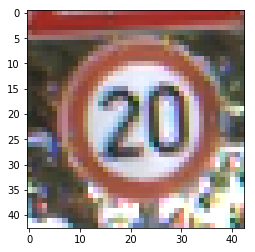

In [7]:
plt.imshow(trainImages[50])
plt.show()

In [60]:
IMG_SIZE = 30 # image_size
LR= 1e-3 #learning rate
MODEL_NAME = 'Traffic_Signs-{}-{}.model'.format(LR,'2conv-basic')

In [62]:
def shuffle_resize_data():
    x_feature = []
    y_feature = []
    data = []
    i = 0
    for img in tqdm(range(len(trainImages))):
        label = one_hot_labels[i]
        gray = cv2.cvtColor(trainImages[img], cv2.COLOR_BGR2GRAY)
        gray_resized = cv2.resize(gray, (IMG_SIZE,IMG_SIZE) ,interpolation = cv2.INTER_CUBIC)
        data.append([np.array(gray_resized), np.array(label)])
        i +=1
    shuffle(data)
    np.save('data.npy',data)
    x_feature , y_feature = zip(*data) 
    return x_feature , y_feature

In [63]:
x_feature , y_feature = shuffle_resize_data()

100%|█████████████████████████████████████████████████████████████████████████| 39209/39209 [00:02<00:00, 14923.50it/s]


In [64]:
#train_data = np.Load('train_data.npy')

In [65]:
print ('trainLabels:',len(y_feature), 'trainImages:',len(x_feature))

trainLabels: 39209 trainImages: 39209


In [66]:
x_feature[100].shape

(30, 30)

In [70]:
y_feature[100].shape

(43,)

### Normalize the data

We need to normalize inputs like this: $$x_{norm} = \frac{x}{255} - 0.5$$

The data frames need to be the form of arrays and normolised. Becuase I'm dealing with grayscale here, I needed to add the dimension at the end of the array else it keras would raise an exception

In [71]:
# normalize the images
#x_train = tf.keras.utils.normalize(x_train)
#x_test = tf.keras.utils.normalize(x_test)

In [72]:
x_train_data = (np.array(x_feature, np.float32) / 255.)
print (x_train_data.shape)
x_train_data = np.expand_dims(x_train_data, axis = 3)
print (x_train_data.shape)

(39209, 30, 30)
(39209, 30, 30, 1)


In [73]:
y_train_data = np.array(y_feature, np.uint8)
print (y_train_data.shape)

(39209, 43)


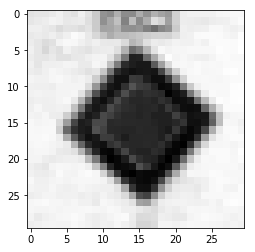

In [74]:
plt.imshow(x_feature[100], cmap=plt.cm.binary)
plt.show()

### Split data to train and test
give 10% for test data from the total data

In [75]:
x_train, x_val, y_train, y_val = train_test_split(x_train_data, y_train_data, test_size=0.1, random_state=2)
print (x_train.shape)
print (x_val.shape)
print (y_train.shape)
print (y_val.shape)

(35288, 30, 30, 1)
(3921, 30, 30, 1)
(35288, 43)
(3921, 43)


# Building the Model

In [76]:
from keras.models import Sequential  # initial NN
from keras.layers import Dense, Dropout # construct each layer
from keras.layers import Convolution2D # swipe across the image by 1
from keras.layers import MaxPooling2D # swipe across by pool size
from keras.layers import Flatten


1. Convetional layer (detect features in image matrix)
2. Pooling layer (recongise features in different angle and/or size)
3. Convetional layer
4. Pooling laye
5. Flattening layer (flatten layers in array of imput)
6. Full connected layer (full connected ANN)
7. Output layer


In [77]:
model = Sequential()

model.add(Convolution2D (filters = 64, kernel_size = (4,4),padding = 'Same', 
                         activation ='relu', input_shape = x_train.shape[1:])) 
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D (filters = 64, kernel_size = (4,4),padding = 'Same', 
                         activation ='relu')) 
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten()) 
# fully connected NN 
model.add(Dense(units = 43, activation = 'relu')) 
# output layer
model.add(Dense(units = 43, activation = 'softmax'))

model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])


In [78]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 64)        1088      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 64)        65600     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 43)                134891    
_________________________________________________________________
dense_4 (Dense)              (None, 43)                1892      
Total para

### Fit the model into data

In [79]:
batch_size = 64 
nb_epochs = 10
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=nb_epochs,
                    verbose=2, 
                    validation_data=(x_val, y_val),
                    initial_epoch=0)

Train on 35288 samples, validate on 3921 samples
Epoch 1/10
28s - loss: 1.7893 - acc: 0.5353 - val_loss: 0.5532 - val_acc: 0.8531
Epoch 2/10
17s - loss: 0.3659 - acc: 0.9070 - val_loss: 0.2427 - val_acc: 0.9324
Epoch 3/10
17s - loss: 0.1809 - acc: 0.9549 - val_loss: 0.1688 - val_acc: 0.9630
Epoch 4/10
17s - loss: 0.1111 - acc: 0.9734 - val_loss: 0.1133 - val_acc: 0.9753
Epoch 5/10
17s - loss: 0.0792 - acc: 0.9808 - val_loss: 0.0990 - val_acc: 0.9765
Epoch 6/10
17s - loss: 0.0588 - acc: 0.9862 - val_loss: 0.0775 - val_acc: 0.9814
Epoch 7/10
17s - loss: 0.0473 - acc: 0.9880 - val_loss: 0.0824 - val_acc: 0.9776
Epoch 8/10
17s - loss: 0.0355 - acc: 0.9916 - val_loss: 0.0736 - val_acc: 0.9847
Epoch 9/10
17s - loss: 0.0312 - acc: 0.9928 - val_loss: 0.1106 - val_acc: 0.9732
Epoch 10/10
17s - loss: 0.0281 - acc: 0.9934 - val_loss: 0.0612 - val_acc: 0.9893


In [80]:
#val_loss, val_acc = model.evaluate(x_test,y_test)

In [82]:
model.save('10epoch_10val_NoMean_2conv') # model_1 = tf.keras.models.load_model('10epoch_10val_NoMean_2conv')

In [ ]:
#predictions = new_model.predict([x_test])